In [11]:
import pandas as pd
df = pd.read_csv('tw_train.csv')
df


,交易日,交易別,股票代號,股票名稱,股數,單價,進帳/出帳,Unnamed: 7,XIRR,總成本(賣-買),總價值(現值+配息),總獲利(%),總配息
0,2021/01/11,買,0050,NaN,130.0,131.90,-17147,NaN,23.39%,-448141.0,719607.0,60.576024,28842.0
1,2021/01/15,買,2330,台積,20.0,612.00,-12240,NaN,NaN,NaN,NaN,NaN,NaN
2,2021/01/20,買,2376,技嘉,40.0,79.50,-3180,NaN,NaN,NaN,NaN,NaN,NaN
3,2021/01/25,買,2330,台積,5.0,644.00,-3220,NaN,NaN,NaN,NaN,NaN,NaN
4,2021/01/29,買,2330,NaN,5.0,603.00,-3015,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024/11/29,買,00631L,NaN,10.0,222.75,-2227,NaN,NaN,NaN,NaN,NaN,NaN
140,2025/01/13,買,006208,NaN,30.0,114.70,-3445,NaN,NaN,NaN,NaN,NaN,NaN
141,2025/01/15,買,006208,NaN,20.0,113.25,-2268,NaN,NaN,NaN,NaN,NaN,NaN
142,2025/01/15,買,00631L,NaN,10.0,232.55,-2328,NaN,NaN,NaN,NaN,NaN,NaN


[*********************100%***********************]  8 of 8 completed



=== 總結報告 ===
累積買入金額：661,551.00 元
淨現金流：-420,402.00 元
實際淨投入資金：420,402.00 元
最終組合市值（現有持股）：681,905.63 元
總獲利：261,503.63 元
總獲利百分比：62.20%
XIRR: 20.88%
最終累積績效: 62.20%
每日 IRR: 0.0449%
年化 IRR: 11.97%
夏普值: 0.7082
最大回撤: -25.43%

=== 投資組合股票明細 ===
+----------+------------+----------------+---------+---------------+--------+----------+------------+
| Symbol   | Name       |   Quantity_now |   Price |   Price_Total |   Cost |     Gain |    Gain(%) |
|----------+------------+----------------+---------+---------------+--------+----------+------------|
| 0050     | 0050       |              0 |  nan    |           nan |  21187 |    349   |   1.64724  |
| 2330     | 台積       |              0 |  nan    |           nan |  39876 |   3004   |   7.53335  |
| 2376     | 技嘉       |            100 |  266.5  |         26650 |   8809 |  17841   | 202.532    |
| 006208   | 006208     |           4566 |  113.95 |        520296 | 364822 | 155474   |  42.6163   |
| 2884     | 玉山金     |              0 |  nan    |       

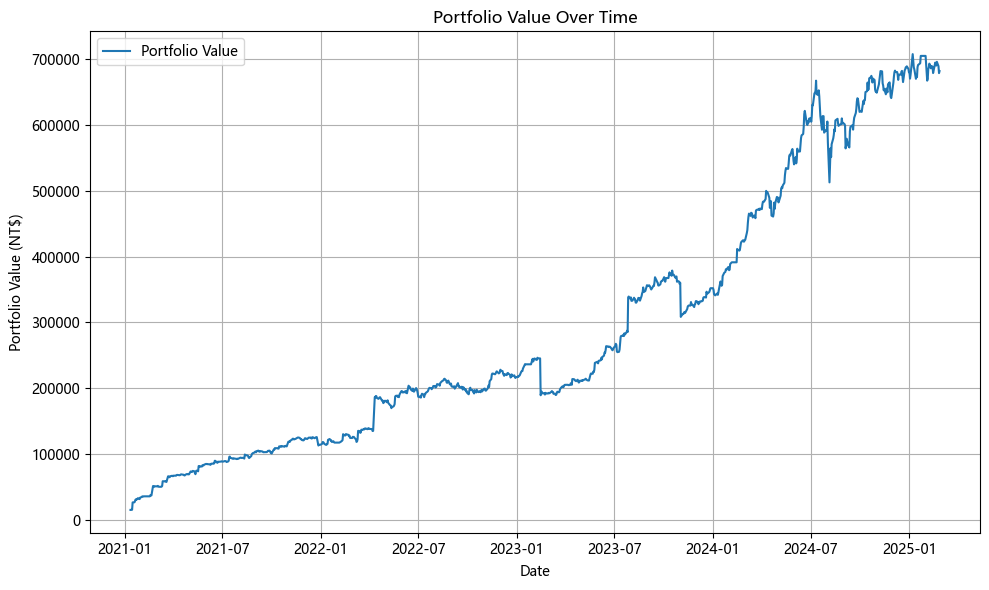

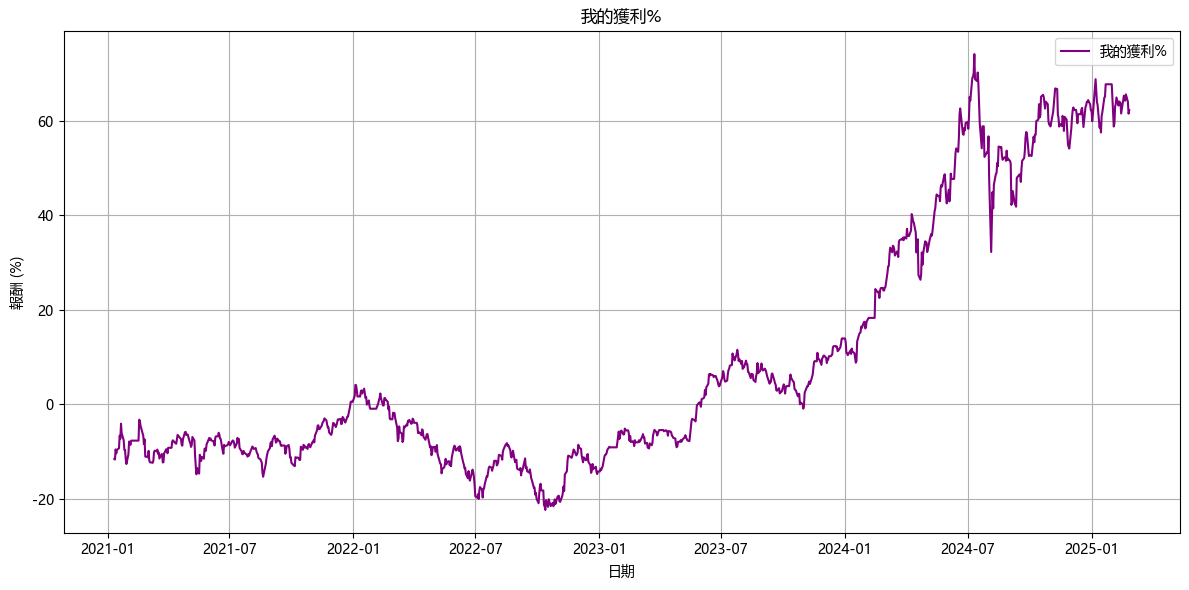

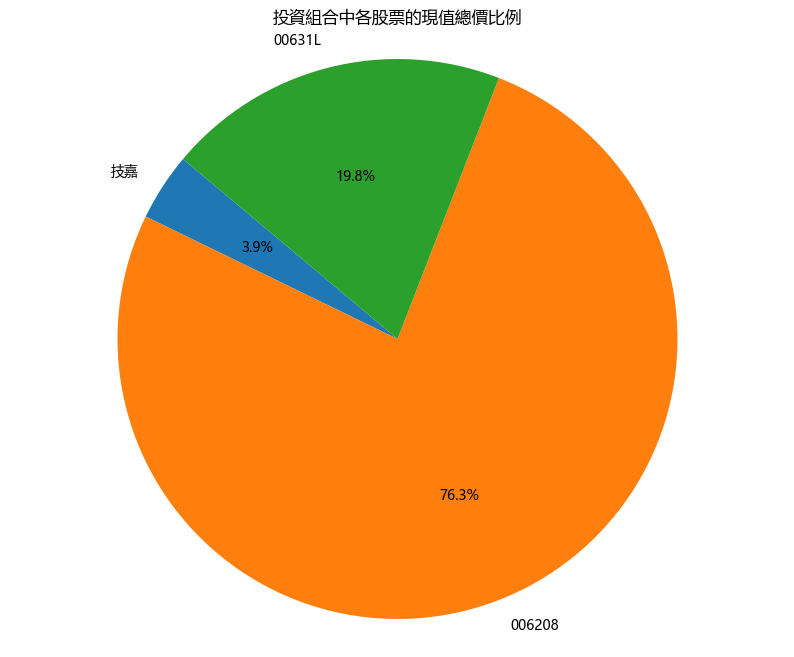

2023/2/10 到 2023/2/15 的市值:
2023-02-10    245303.561150
2023-02-13    245381.954605
2023-02-14    189410.040756
2023-02-15    192768.624046
Freq: B, dtype: float64

查詢期間每日市值:
2023-02-10    245303.561150
2023-02-11    245303.561150
2023-02-12    245303.561150
2023-02-13    245381.954605
2023-02-14    189410.040756
2023-02-15    192768.624046
Freq: D, dtype: float64


In [49]:
%run tw.py

[*********************100%***********************]  6 of 6 completed



=== 總結報告 ===
累積買入金額：35,491.21 元
淨現金流：-18,271.35 元
實際淨投入資金：18,271.35 元
最終組合市值（現有持股）：23,341.60 元
總獲利：5,070.25 元
總獲利百分比：27.75%
XIRR: 15.92%
最終累積績效: 27.75%
每日 IRR: 0.0296%
年化 IRR: 7.75%
夏普值: 0.4997
最大回撤: -65.22%

=== 投資組合股票明細 ===
+----------+--------+----------------+---------+---------------+----------+-----------+------------+
| Symbol   | Name   |   Quantity_now |   Price |   Price_Total |     Cost |      Gain |    Gain(%) |
|----------+--------+----------------+---------+---------------+----------+-----------+------------|
| TQQQ     | TQQQ   |              0 |  nan    |        nan    |  6175.88 | 3441.68   |  55.7278   |
| EDV      | EDV    |             61 |   71.89 |       4385.29 |  4935.46 | -550.17   | -11.1473   |
| TMF      | TMF    |              0 |  nan    |        nan    |    57.79 |  -42.06   | -72.7808   |
| VOO      | VOO    |              0 |  nan    |        nan    |  3425.97 |  507.63   |  14.8171   |
| SPLG     | SPLG   |             95 |   70.41 |       6688.95 |  

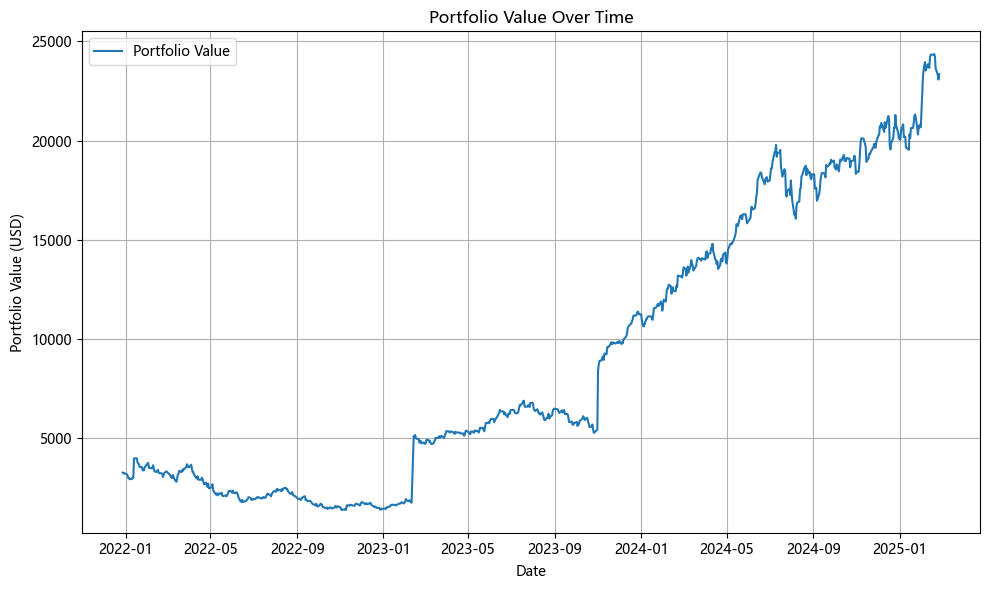

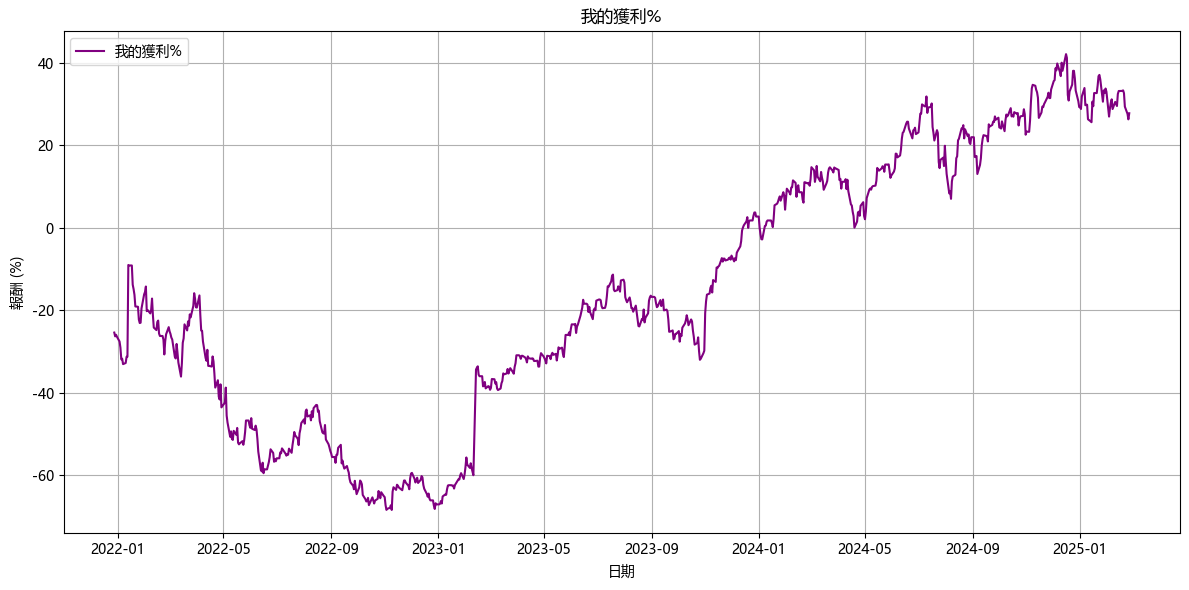

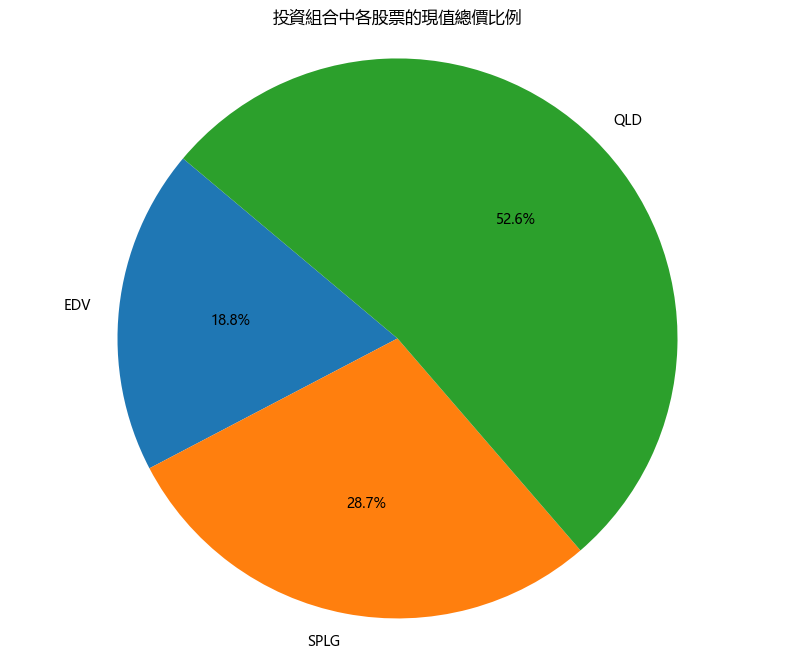

2023/2/10 到 2023/2/15 的市值:
2023-02-10    1744.173903
2023-02-13    5092.296612
2023-02-14    5127.212673
2023-02-15    5152.440823
Freq: B, dtype: float64

查詢期間每日市值:
2023-02-10    1744.173903
2023-02-11    1744.173903
2023-02-12    1744.173903
2023-02-13    5092.296612
2023-02-14    5127.212673
2023-02-15    5152.440823
Freq: D, dtype: float64


In [50]:
%run us.py

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  6 of 6 completed



=== 綜合資產配置報告 (單位: USD) ===
累積買入金額：55,678.30 USD
實際淨投入資金：31,099.83 USD
最終組合市值：44,209.92 USD
總獲利：13,110.10 USD
總獲利百分比：42.15%
綜合 XIRR: 18.75%

=== 綜合投資組合股票明細 ===
+----------+------------+----------------+-----------+---------------+-----------+----------+-----------+
| Symbol   | Name       |   Quantity_now |     Price |   Price_Total |      Cost | Gain     | Gain(%)   |
|----------+------------+----------------+-----------+---------------+-----------+----------+-----------|
| 0050     | 0050       |              0 |   0       |         0     |   646.517 | 10.65    | 1.65%     |
| 2330     | 台積       |              0 |   0       |         0     |  1216.81  | 91.67    | 7.53%     |
| 2376     | 技嘉       |            100 |   8.13219 |       813.219 |   268.805 | 544.41   | 202.53%   |
| 006208   | 006208     |           4566 |   3.47716 |     15876.7   | 11132.5   | 4,744.25 | 42.62%    |
| 2884     | 玉山金     |              0 |   0       |         0     |   188.032 | 18.25    | 9.70%     |

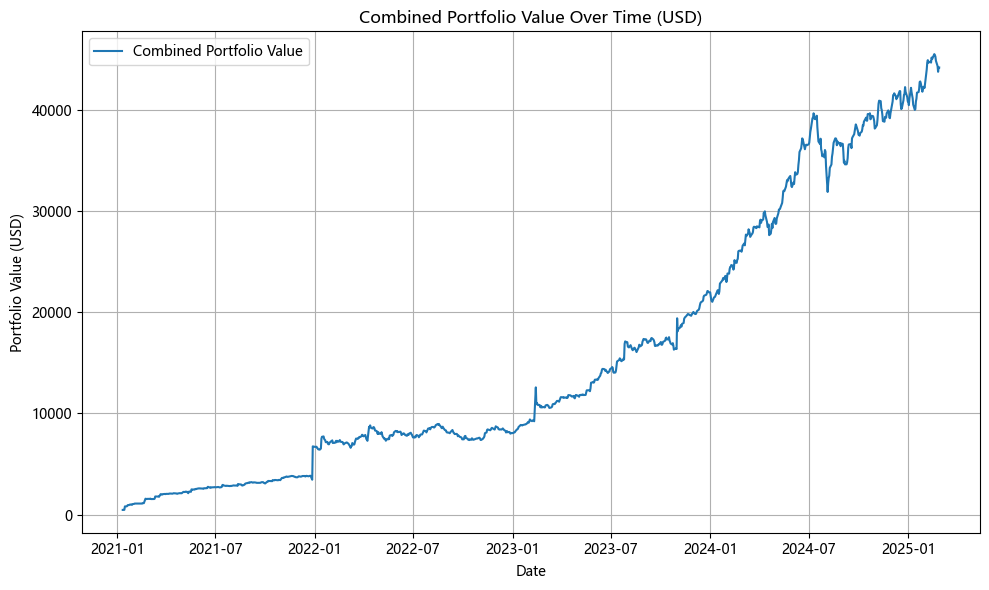

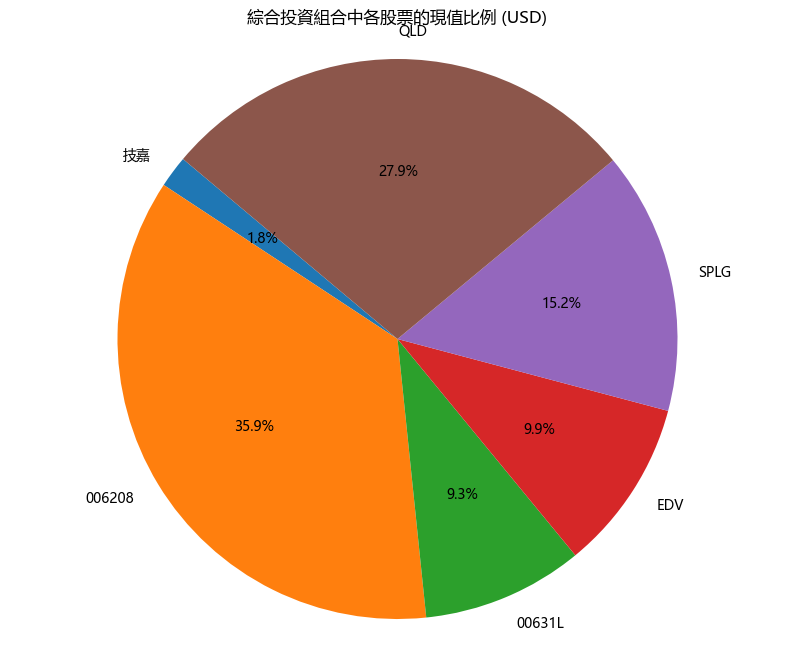

In [56]:
%run combine.py